In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

import numpy as np
import pandas as pd

pd.options.display.float_format = "{:.5f}".format

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
CWD = os.getcwd()
PY8TB_PATH = os.path.dirname(CWD)
SAVE_PATH = os.path.join(PY8TB_PATH, "data")
DF_PATH = os.path.join(SAVE_PATH, "df_2024_06_22_19_24_53.parquet.gzip")

In [3]:
sys.path.insert(0, PY8TB_PATH)

In [4]:
from py8tb import TOP_FILE_EXTENSIONS

In [5]:
df = pd.read_parquet(path=DF_PATH)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146072 entries, 0 to 146071
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FilePath              146072 non-null  object 
 1   CreationDate          146072 non-null  object 
 2   LastModificationDate  146072 non-null  object 
 3   SizeMB                146072 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.5+ MB


In [7]:
df.shape

(146072, 4)

In [8]:
df.sample(10)

,FilePath,CreationDate,LastModificationDate,SizeMB
32204,/Volumes/MUPU 4TB 1/MUPU 500GB/Fotos/1024x768-...,2021-08-07 20:47:39,2019-08-28 03:01:52,0.51881
142407,/Volumes/MUPU 4TB 2/BACKUPS/1_BACKUP_ONEPLUS_2...,2023-02-12 20:36:28,2022-10-30 10:15:22,0.11018
35409,/Volumes/MUPU 4TB 1/MUPU 500GB/Fotos/1200x1600...,2021-08-07 20:48:23,2019-08-28 03:17:04,0.31453
6380,/Volumes/MUPU 4TB 1/GoPro Videos/20211231_Misc...,2022-02-05 20:28:42,2022-01-24 13:15:08,0.07886
106890,/Volumes/MUPU 4TB 1/MUPU 500GB/Videos/posibles...,2021-08-07 22:00:47,2017-04-14 17:14:48,25.80915
68361,/Volumes/MUPU 4TB 1/MUPU 500GB/Fotos/T1-(2007-...,2021-08-07 21:53:21,2019-08-28 04:03:02,0.00537
137278,/Volumes/MUPU 4TB 2/BACKUPS/1_BACKUP_ONEPLUS_2...,2023-02-12 20:18:07,2023-02-12 16:44:02,0.01442
139859,/Volumes/MUPU 4TB 2/BACKUPS/1_BACKUP_ONEPLUS_2...,2023-02-12 20:24:30,2023-01-12 06:27:37,0.01329
43544,/Volumes/MUPU 4TB 1/MUPU 500GB/Fotos/367173c0-...,2021-08-07 20:52:01,2018-07-24 17:26:44,0.09444
20481,/Volumes/MUPU 4TB 1/MUPU 500GB/Fotos/(2017-01-...,2021-08-07 20:09:28,2019-08-28 03:40:10,2.64409


# Duplicado: todo fichero que ha sido creado, modificado y tiene el mismo tamaño.

In [9]:
def custom_mapping(file_extension):

    if str.lower(file_extension) in TOP_FILE_EXTENSIONS.keys():
        return TOP_FILE_EXTENSIONS[str.lower(file_extension)]
    else:
        return "na"

In [10]:
df = df.assign(
    FileName=df["FilePath"].apply(os.path.basename),
    FileExtension=df["FilePath"].apply(
        lambda file_path: str.lower(os.path.splitext(file_path)[1])
    ),
    FileType=lambda df: df["FileExtension"].apply(custom_mapping),
)

In [11]:
photos = df[df["FileType"] == "photo"]

In [12]:
photos.to_parquet(os.path.join(SAVE_PATH, "photos.parquet.gzip"))

In [13]:
top_file_extesions = pd.concat(
    [
        df["FileExtension"].value_counts(),
        df["FileExtension"].value_counts(normalize=True),
    ],
    axis=1,
).assign(CumSum=lambda df: df["proportion"].cumsum())

In [14]:
# Using top 20 file extesions we created the TOP_FILE_EXTENSIONS
# and mapped it to the file type (audio, video, photo etc)
top_file_extesions.head(20)

,count,proportion,CumSum
FileExtension,,,
.jpg,60917,0.41703,0.41703
.jpeg,49586,0.33946,0.75650
.mp4,17539,0.12007,0.87657
.file,4100,0.02807,0.90464
.heic,2922,0.02000,0.92464
,2771,0.01897,0.94361
.mov,890,0.00609,0.94970
.opus,848,0.00581,0.95551
.m4v,840,0.00575,0.96126


In [15]:
file_size_and_counter_by_type = (
    df.groupby(["FileExtension", "FileType"])
    .agg(
        NrFiles=("FilePath", len),
        TotalSizeMB=("SizeMB", np.sum),
        TotalSizeGB=("SizeMB", lambda series: np.sum(series) / (1024)),  # GB
    )
    .reset_index()
    .assign(
        NrFilesByType=lambda df: df.groupby("FileType")["NrFiles"].transform(np.sum),
        TotalSizeMBByType=lambda df: df.groupby("FileType")["TotalSizeMB"].transform(
            np.sum
        ),
        PctNrFilesByType=lambda df: df["NrFiles"] / df["NrFilesByType"],
        PctSizeMBByType=lambda df: df["TotalSizeMB"] / df["TotalSizeMBByType"],
    )
    .query("FileType == 'video' or FileType == 'photo'")
    .sort_values("FileType", ascending=False)
)

In [16]:
file_size_and_counter_by_type

,FileExtension,FileType,NrFiles,TotalSizeMB,TotalSizeGB,NrFilesByType,TotalSizeMBByType,PctNrFilesByType,PctSizeMBByType
35,.exo,video,318,262.57821,0.25642,19587,5479747.95480,0.01624,0.00005
64,.m4v,video,840,41896.45847,40.91451,19587,5479747.95480,0.04289,0.00765
70,.mov,video,890,123866.75374,120.96363,19587,5479747.95480,0.04544,0.02260
72,.mp4,video,17539,5313722.16438,5189.18180,19587,5479747.95480,0.89544,0.96970
43,.heic,photo,2922,6754.06400,6.59577,114951,168239.58322,0.02542,0.04015
52,.jpeg,photo,49586,81340.06443,79.43366,114951,168239.58322,0.43137,0.48348
53,.jpg,photo,60917,79533.00070,77.66895,114951,168239.58322,0.52994,0.47274
90,.png,photo,728,553.77241,0.54079,114951,168239.58322,0.00633,0.00329
118,.webp,photo,798,58.68167,0.05731,114951,168239.58322,0.00694,0.00035


In [17]:
df = df[df["FileType"].isin(["photo", "video"])]

In [18]:
df.sort_values(["CreationDate", "LastModificationDate", "SizeMB"], inplace=True)

In [19]:
df["Counter"] = df.groupby(
    [
        # "FileName",
        "CreationDate",
        "LastModificationDate",
        "SizeMB",
    ]
)["FilePath"].transform(len)

In [20]:
df["Counter"].value_counts()

Counter
1     120404
2      10910
3       1947
4        740
5        285
6        126
7         63
9         45
18        18
Name: count, dtype: int64

In [21]:
df.loc[998]

FilePath                /Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...
CreationDate                                          2023-01-07 16:58:38
LastModificationDate                                  2020-11-14 17:26:00
SizeMB                                                            3.21283
FileName                                          IMG_20200903_122929.jpg
FileExtension                                                        .jpg
FileType                                                            photo
Counter                                                                 3
Name: 998, dtype: object

In [22]:
df[
    (df["CreationDate"] == "2023-01-07 16:58:38")
    & (df["LastModificationDate"] == "2020-11-14 17:26:00")
    & (df["SizeMB"] > 3)
]

,FilePath,CreationDate,LastModificationDate,SizeMB,FileName,FileExtension,FileType,Counter
1000,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,3.00424,IMG_20200919_141011.jpg,.jpg,photo,3
1006,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,3.00424,IMG_20200919_141011.jpg,.jpg,photo,3
1025,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,3.00424,IMG_20200919_141011.jpg,.jpg,photo,3
999,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,3.07762,IMG_20200903_123539.jpg,.jpg,photo,3
1005,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,3.07762,IMG_20200903_123539.jpg,.jpg,photo,3
1024,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,3.07762,IMG_20200903_123539.jpg,.jpg,photo,3
998,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,3.21283,IMG_20200903_122929.jpg,.jpg,photo,3
1004,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,3.21283,IMG_20200903_122929.jpg,.jpg,photo,3
1023,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,3.21283,IMG_20200903_122929.jpg,.jpg,photo,3
1002,/Volumes/MUPU 4TB 1/code/python10pm_repo/pytho...,2023-01-07 16:58:38,2020-11-14 17:26:00,4.10705,Tibidabo_IMG_20200919_165053.jpg,.jpg,photo,3


In [23]:
df["FileType"].value_counts()

FileType
photo    114951
video     19587
Name: count, dtype: int64

In [24]:
path_ = df.loc[35009]["FilePath"]
path_ = df.loc[35010]["FilePath"]
path_ = df.loc[35014]["FilePath"]

path_ = df.loc[69525]["FilePath"]

# path_ = df.loc[93741]["FilePath"]

path_ = df.loc[998]["FilePath"]
path_ = df.loc[1004]["FilePath"]

path_ = df.loc[1000]["FilePath"]
# path_ = df.loc[997]["FilePath"]

In [25]:
path_

'/Volumes/MUPU 4TB 1/code/python10pm_repo/pythoneando-main/Video_3_principios_básicos_de_la_programación/Archivos/Tibidabo/IMG_20200919_141011.jpg'

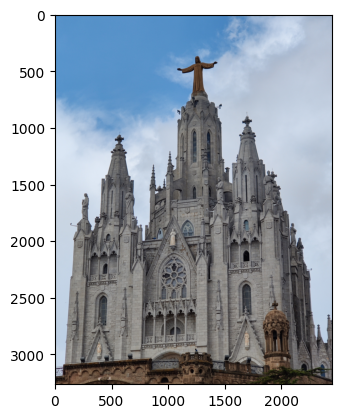

In [26]:
img = mpimg.imread(path_)
imgplot = plt.imshow(img)
plt.show()

# sha256 in python

In [27]:
def calculate_sha256_of_image(file_path):

    from hashlib import sha256

    print(file_path)
    with open(file_path, "rb") as f:
        content = f.read()
        content_in_bytes = bytearray(content)

    sha256_img = sha256(string=content_in_bytes).hexdigest()

    return sha256_img

In [28]:
calculate_sha256_of_image(file_path=df.loc[998]["FilePath"])

/Volumes/MUPU 4TB 1/code/python10pm_repo/pythoneando-main/Video_3_principios_básicos_de_la_programación/Archivos/CosmoCaixa/IMG_20200903_122929.jpg


'60b17f6fe383e430532091b1c3a2ea06371cef19777d7090dc19c8d0e96c4e78'

In [29]:
calculate_sha256_of_image(file_path=df.loc[1004]["FilePath"])

/Volumes/MUPU 4TB 1/code/python10pm_repo/pythoneando-main/Video_3_principios_básicos_de_la_programación/Ficheros_conjuntos/IMG_20200903_122929.jpg


'60b17f6fe383e430532091b1c3a2ea06371cef19777d7090dc19c8d0e96c4e78'

In [30]:
calculate_sha256_of_image(file_path=df.loc[1023]["FilePath"])

/Volumes/MUPU 4TB 1/code/python10pm_repo/pythoneando-main/Video_6_if_name_main/input/IMG_20200903_122929.jpg


'60b17f6fe383e430532091b1c3a2ea06371cef19777d7090dc19c8d0e96c4e78'

In [31]:
calculate_sha256_of_image(file_path=df.loc[1000]["FilePath"])

/Volumes/MUPU 4TB 1/code/python10pm_repo/pythoneando-main/Video_3_principios_básicos_de_la_programación/Archivos/Tibidabo/IMG_20200919_141011.jpg


'957855100ab887a37cd9d970cb56bf014e8109d4a5b46292f8a32d872d470032'

In [32]:
calculate_sha256_of_image(file_path=df.loc[1006]["FilePath"])

/Volumes/MUPU 4TB 1/code/python10pm_repo/pythoneando-main/Video_3_principios_básicos_de_la_programación/Ficheros_conjuntos/IMG_20200919_141011.jpg


'957855100ab887a37cd9d970cb56bf014e8109d4a5b46292f8a32d872d470032'

In [33]:
calculate_sha256_of_image(file_path=df.loc[1025]["FilePath"])

/Volumes/MUPU 4TB 1/code/python10pm_repo/pythoneando-main/Video_6_if_name_main/input/IMG_20200919_141011.jpg


'957855100ab887a37cd9d970cb56bf014e8109d4a5b46292f8a32d872d470032'